# Libraries and Google Drive

In [ ]:
pip install owslib rasterio

In [219]:
import pandas as pd
import numpy as np
import geopandas as gpd

from owslib.wms import WebMapService
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display
from IPython.display import Image as displayImage

import io
from io import BytesIO
import time
import random

import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
from rasterio.crs import CRS

import shapely
from shapely.geometry import Polygon, LineString

from pyproj import Geod
from pyproj import Transformer
from geopy.distance import distance

import math

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import csv of correctly labelled service stations and extract associated polygons

In [ ]:
# Load verified_service_stations csv and transform to list
verified_service_stations_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/verified_service_stations.csv'

# Read the CSV file into a pandas DataFrame
verified_service_stations = pd.read_csv(verified_service_stations_path)

# Transform df to list
verified_service_stations_list = []
for row in verified_service_stations.values.tolist():
    verified_service_stations_list.extend(row)

# Print first 5 items
print("Sample list output:", verified_service_stations[:5])
print("\n")
print("Number of correctly labelled service stations:", len(verified_service_stations_list))

Sample list output:                          id_rest
0   lon_8.6630029_lat_50.2542348
1  lon_11.3531491_lat_50.9378362
2   lon_9.6300119_lat_53.8303266
3   lon_9.6297338_lat_53.8301666
4  lon_11.0102562_lat_50.8353109


Number of correctly labelled service stations: 267


In [ ]:
# Load the GeoJSON files containing service station polygons and truck/car parking polygons together with service station IDs (created in 01a_OSM_rest_stops.ipynb)
all_parkings = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/all_parkings.geojson") # polygons of car and truck parking space
rest_stations = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/rest_stations.geojson") # polygons and ids of rest stations

In [ ]:
# Create geopandas geodataframes that only contain polygons of correctly labelled service stations

print("Shape of all_parkings before dropping irrelevant rows:", all_parkings.shape)
print("Shape of rest_stations before dropping irrelevant rows:", rest_stations.shape)

# Drop all rows not corresponding to correctly labelled service stations
parking_areas_ver = all_parkings[all_parkings["id_rest"].isin(verified_service_stations_list)] # renamed variable!
rest_stations_ver = rest_stations[rest_stations["id"].isin(verified_service_stations_list)]

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of all_parkings before dropping irrelevant rows: (1606, 6)
Shape of rest_stations before dropping irrelevant rows: (506, 5)
Shape of parking_areas_ver: (1190, 6)
Shape of rest_stations after dropping irrelevant rows: (267, 5)


In [ ]:
# Drop irrelevant columns, reorder columns, reset index of parkings_areas_ver

parking_areas_ver = parking_areas_ver.drop(["id_car", "name"], axis = 1)
parking_areas_ver = parking_areas_ver.rename(columns={"@id": "id_OSM_parking"})
parking_areas_ver = parking_areas_ver.reindex(columns=["id_rest", "id_OSM_parking", "type", "geometry"])
parking_areas_ver = parking_areas_ver.reset_index(drop = True)

parking_areas_ver.head()

,id_rest,id_OSM_parking,type,geometry
0,lon_7.5846163_lat_53.2588511,way/33526884,car,"POLYGON ((7.58527 53.25883, 7.58618 53.25869, ..."
1,lon_7.2005154_lat_52.2816225,way/38125314,car,"POLYGON ((7.19685 52.28128, 7.19692 52.28127, ..."
2,lon_10.7306355_lat_50.559048,way/48905621,car,"POLYGON ((10.73083 50.55915, 10.73087 50.55881..."
3,lon_10.7298729_lat_50.5605634,way/48925325,car,"POLYGON ((10.72986 50.56033, 10.72980 50.56026..."
4,lon_13.9503161_lat_52.3112817,way/65260801,car,"POLYGON ((13.95364 52.31074, 13.95274 52.31075..."


In [ ]:
# Drop irrelevant columns, reorder columns, reset index of rest_stations_ver

rest_stations_ver = rest_stations_ver.rename(columns={"id": "id_rest", "@id": "id_OSM_rest"})
rest_stations_ver = rest_stations_ver.drop("highway", axis = 1)
rest_stations_ver = rest_stations_ver.reset_index(drop = True)

rest_stations_ver.head()

,id_rest,id_OSM_rest,name,geometry
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"POLYGON ((8.66300 50.25423, 8.66302 50.25237, ..."
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"POLYGON ((11.35315 50.93784, 11.35315 50.93783..."
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"POLYGON ((9.63001 53.83033, 9.63273 53.82905, ..."
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"POLYGON ((9.62973 53.83017, 9.62965 53.83010, ..."
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"POLYGON ((11.01026 50.83531, 11.01145 50.83591..."


In [ ]:
# Check shapes of dataframes

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of parking_areas_ver: (1190, 4)
Shape of rest_stations after dropping irrelevant rows: (267, 4)


In [ ]:
# Download geopandas geodataframes as GeoJSONs

# Specify the path where you want to save the GeoJSON file
output_path_parking_areas_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson"
output_path_rest_stations_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson"

# Export the GeoPandas DataFrame to GeoJSON
parking_areas_ver.to_file(output_path_parking_areas_ver, driver='GeoJSON')
rest_stations_ver.to_file(output_path_rest_stations_ver, driver='GeoJSON')

# Set up tile services

## WMS and layer information

This code was partly taken from: [OWSLib 0.29.3 documentation -> Examples -> Interact with a WMS](https://owslib.readthedocs.io/en/stable/notebooks/wms.html)

In [ ]:
# Define WMS service and layer to be tested

test_wms_url = "https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS"
test_layer = "WMS_NI_DOP"

In [ ]:
# Functions to return WMS/ layer information

def get_wms_information(wms_url):
    """
    Output all necessary WMS information for the WMS service provided.

    Parameters:
    wms_url: The GetCapabilities url of the WMS service

    Returns:
    A dictionary with version, url, title, abstract, provider_name, layer_names, operations, operations_urls, format_options
    """

    wms = WebMapService(wms_url, version="1.3.0")

    version = wms.identification.version
    title = wms.identification.title
    abstract = wms.identification.abstract
    provider_name = wms.provider.name
    layer_names = list(wms.contents)
    operations = [op.name for op in wms.operations]
    operations_urls = wms.getOperationByName("GetMap").methods
    format_options = wms.getOperationByName("GetMap").formatOptions

    wms_information = {"version": version,
                       "url": wms_url,
                       "title": title,
                       "abstract": abstract,
                       "provider_name": provider_name,
                       "layer_names": layer_names,
                       "operations": operations,
                       "operations_urls": operations_urls,
                       "format_options": format_options
                       }

    return wms_information

def get_layer_information(wms_url, layer_name):
    """
    Retrieve information about extent and crs_options of selected layer.

    Paramters:
    wms_url: The GetCapabilities url of the WMS service
    layer_name: The name of the selected layer

    Returns:
    A dictionary with layer_name, extent, crs_options.
    """

    wms = WebMapService(wms_url, version="1.3.0")

    extent = wms.contents[layer_name].boundingBoxWGS84
    crs_options = wms[layer_name].crsOptions

    layer_information = {"layer_name": layer_name,
                         "extent": extent,
                         "crs_options": crs_options
                         }

    return layer_information

In [ ]:
# Return all relevant WMS service information
get_wms_information(test_wms_url)

{'version': '1.3.0',
 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS',
 'title': 'WMS NI DOP',
 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)',
 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation',
 'layer_names': ['WMS_NI_DOP', 'dop20'],
 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'],
 'operations_urls': [{'type': 'Get',
   'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'},
  {'type': 'Post',
   'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}],
 'format_options': ['image/png',
  'image/jpeg',
  'image/png; mode=8bit',
  'image/vnd.jpeg-png',
  'image/vnd.jpeg-png8',
  'application/x-pdf',
  'image/svg+xml',
  'image/tiff',
  'application/vnd.google-earth.kml+xml',
  'application/vnd.google-earth.kmz',
  'application/vn

In [ ]:
# Return all relevant layer information
get_layer_information(test_wms_url, test_layer)

{'layer_name': 'WMS_NI_DOP',
 'extent': (6.505772, 51.153098, 11.754046, 54.148101),
 'crs_options': ['EPSG:3044',
  'EPSG:4326',
  'EPSG:4258',
  'EPSG:31466',
  'EPSG:32632',
  'EPSG:3034',
  'EPSG:31467',
  'EPSG:3045',
  'EPSG:3035',
  'EPSG:31468',
  'EPSG:31469',
  'EPSG:32633',
  'EPSG:4647',
  'EPSG:25833',
  'EPSG:25832',
  'EPSG:3857']}

## Return image from WMS bbox

### Set-up

In [226]:
# Define WMS service and layer for each German state

wms_urls = {
        'WMS_NI_DOP': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', # Lower Saxony
        'bebb_dop20c': 'https://isk.geobasis-bb.de/mapproxy/dop20c/service/wms?Request=GetCapabilities&Service=WMS', # Brandenburg & Berlin
        'th_dop': 'https://www.geoproxy.geoportal-th.de/geoproxy/services/DOP?REQUEST=GetCapabilities&version=1.1.1&service=WMS', # Thuringia
        'lsa_lvermgeo_dop20_2': 'https://www.geodatenportal.sachsen-anhalt.de/wss/service/ST_LVermGeo_DOP_WMS_OpenData/guest?', # Saxony-Anhalt
        'he_dop_rgb': 'https://gds-srv.hessen.de/cgi-bin/lika-services/ogc-free-images.ows?', # Hessia
        'sh_dop20_rgb': 'https://dienste.gdi-sh.de/WMS_SH_DOP20col_OpenGBD?Service=wms&version=1.3.0&request=getCapabilities', # Schleswig-Holstein
    }

*   sh_dop20_rgb has an overly large, inaccurate extent. For this reason, this layer is tested last

In [227]:
# Print WMS and layer information for all selected Länder layers
counter = 1

for layer, url in wms_urls.items():
    print(f"wms_{counter}", get_wms_information(url))
    print(f"layer_{counter}", get_layer_information(url, layer))
    print("\n")
    counter += 1

wms_1 {'version': '1.3.0', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', 'title': 'WMS NI DOP', 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)', 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation', 'layer_names': ['WMS_NI_DOP', 'dop20'], 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'], 'operations_urls': [{'type': 'Get', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}, {'type': 'Post', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}], 'format_options': ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8', 'application/x-pdf', 'image/svg+xml', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz', 'application/vnd.mapbox-vector-tile', 'applic

**Findings:**

*   All layers have the option to select the EPSG:4326 coordinate system, a coordinate system on the WGS84 reference ellipsoid
*   WGS84 is also used as the standard coordinates system used by GSP and also OSM
*   Only Niedersachsen, Thüringen and Hessen can export in Tiff format

In [228]:
def retrieve_layer_extents(wms_urls):
        """
        Retrieve layer extents of the WMS urls.

        Parameters:
        wms_urls (dict): dictionary of layer names and WMS GetCapability URLs

        Returns:
        A dictionary of the extents of the WMS layers.
        """
        wms_layer_extents = {}

        for layer_name, url in wms_urls.items():
            bounding_box = get_layer_information(url, layer_name)["extent"]
            wms_layer_extents[layer_name] = bounding_box

        return wms_layer_extents

In [229]:
# Extract layer extents
layer_extents = retrieve_layer_extents(wms_urls)
print(layer_extents)

{'WMS_NI_DOP': (6.505772, 51.153098, 11.754046, 54.148101), 'bebb_dop20c': (11.152768795679583, 51.2635170116316, 15.009068839315324, 53.61004915755329), 'th_dop': (9.70043908, 50.13516795, 12.75958006, 51.7188448), 'lsa_lvermgeo_dop20_2': (10.5092, 50.8927, 13.3233, 53.0769), 'he_dop_rgb': (7.41867, 49.25, 10.5, 51.7596), 'sh_dop20_rgb': (0.105946742406, 45.237542736, 20.4488912945, 56.8478734515)}


In [236]:
def create_png_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square png map from a bounding box sourced from WMS services.

    Parameters:
    bbox (tuple): (left, bottom, right, top)
    wms_urls (dict): dictionary containing layer_names as keys and urls as values
    layer_extents (dict): dictionary containing layer_names as keys and layer extent tuples as values
    size (int): determines the size of the output png in pixels

    Returns:
    A square png image of the map.
    """


    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.

        Parameters:
        bbox1, bbox2 (tuple): tuple of bbox corners (left, bottom, right, top)

        Returns:
        True if bboxes intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        """
        Check whether an image is blank or not.

        Parameters:
        image (image object): image of WMS service

        Returns:
        True if image is blank, False otherwise.
        """
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, check whether image is completely white or black
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                # Check if the image is completely white or black
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # Raise error for other image mode
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False


    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based for the provided bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)
        wms_urls (dict): dictionary containing layer_names as keys and urls as values
        layer_extents: dictionary of layer names and their extent bounding boxes

        Returns:
        Layer name or None if no intersection
        """
        # Check WMSs one after the other until image is returned
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:3857',
                              bbox=square_bbox,
                              size=(2, 2),
                              format='image/png')
            # First, check if bounding box intersects
            #if not bbox_intersects(bbox, extent):
            #    print(f"{layer} does not contain bounding box.")
            # Second, check whether image is blank
            if is_blank_image(response):
                print(f"{layer} returns blank image.")
            # Return image
            else:
                print(f"{layer} returns image.")

                return layer
        return None


    def encapsulate_in_square_bbox(bbox):
        """
        Create encapsulating, square bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)

        Returns:
        A square bounding box that encapsulates input bounding box.
        """

        # Extract corners
        lat_min, lon_min, lat_max, lon_max = bbox

        # Calculate the midpoints of the existing bounding box
        mid_lat = (lat_max + lat_min) / 2
        mid_lon = (lon_max + lon_min) / 2

        # Calculate the max spans
        span_lat = (lat_max - lat_min) / 2
        span_lon = (lon_max - lon_min) / 2

        max_span = max(span_lat, span_lon)

        # Calculate new bbox corners
        lat_min_new = mid_lat - max_span
        lat_max_new = mid_lat + max_span
        lon_min_new = mid_lon - max_span
        lon_max_new = mid_lon + max_span

        square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

        return square_bbox


    # Create square bounding box from input bounding box
    square_bbox = encapsulate_in_square_bbox(bbox)

    # Determine the layer that intersects the bounding box
    chosen_layer = determine_layer_for_bbox(square_bbox, wms_urls, layer_extents)

    if chosen_layer == None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        # Correctly create a WebMapService object from chosen layer
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:3857',
                              bbox=square_bbox,
                              size=(size, size),
                              format='image/png')
    # Return the image
    return response

In [231]:
def pixel_dimensions(image):
    """
    Return pixel dimensions of an image.

    Parameters:
    image (PIL Image object)

    Returns:
    A tuple of width and height dimensions of the input image.
    """

    image_data = BytesIO(image.read())
    image_loaded = Image.open(image_data)

    # Get image dimensions (Width x Height)
    width, height = image_loaded.size

    return (width, height)

### Test image return for test service stations in different states

In [182]:
# Define test bounding boxes In EPSG 4326

test_bbox_niedersachsen = [8.42191544, 52.91467249, 8.42508244, 52.91489671]
test_bbox_brandenburg = [13.015424, 52.300345, 13.020988, 52.302384]
test_bbox_thüringen = [11.196242, 50.947367, 11.200492, 50.948778]
test_bbox_sh = [9.939001, 53.717082, 9.939979, 53.720104]
test_bbox_hessen = [8.350782, 50.094450, 8.354213, 50.099812]
test_bbox_fail = [8.4231, 48.375354, 8.4421, 48.385273] # bbox not within covered area, should return error message
test_bbox_magdeburg = [11.448439, 52.183663, 11.455710, 52.186811] # magdeburg convered by several extents, but should return image from lsa layer

In [220]:
def transform_bbox(bbox, from_epsg, to_epsg):
    """
    Transform a bounding box from one EPSG code to another.

    Parameters:
    bbox (list): Bounding box as [left, bottom, right, top] in the from_epsg coordinate system.
    from_epsg (int): EPSG code of the current coordinate system.
    to_epsg (int): EPSG code of the target coordinate system.

    Returns:
    Transformed bounding box as [left, bottom, right, top] in the to_epsg coordinate system.
    """

    # Create a transformer object for the conversion
    transformer = Transformer.from_crs(f"EPSG:{from_epsg}", f"EPSG:{to_epsg}", always_xy=True)

    # Transform each corner of the bounding box
    left, bottom = transformer.transform(bbox[0], bbox[1])
    right, top = transformer.transform(bbox[2], bbox[3])

    return [left, bottom, right, top]

In [224]:
# Example usage
test_bbox_niedersachsen_3857 = transform_bbox(test_bbox_niedersachsen, 4326, 3857)

In [237]:
# Test create_png_from_bbox function
try:
    # Input bbox to be tested
    response = create_png_from_bbox(test_bbox_niedersachsen_3857, wms_urls, layer_extents, size = 1000)
    # Further code to handle the response
except ValueError as e:
    print(e)

WMS_NI_DOP returns image.


In [238]:
# Display returned image

displayImage(response.read())

Output hidden; open in https://colab.research.google.com to view.

In [234]:
print("Image pixel dimensions", pixel_dimensions(response))

Image pixel dimensions (1000, 1000)


# Load GeoJSONs and define bounding boxes for download

In [186]:
# Load the GeoJSON files of verified rest stops
parking_areas_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson") # polygons of verified car and truck parking space
rest_stations_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson") # polygons of verified rest stops

### Find minimum needed image size (pixels) to show maximum resolution

In [188]:
# del later

def find_biggest_rest_station(geodataframe):
    """
    Returns the biggest rest station.

    Parameters:
    geodataframe (geopandas geodataframe): contains polygon/multipolygon geometries

    Returns:
    The id of the biggest rest station.
    """

    def polygon_to_bbox(polygon):
        """
        Transforms a polygon into a square bounding box.

        Parameters:
        polygon (Polygon): input polygon

        Returns:
        The resulting square bounding box bounds as a list: [left, bottom, right, top].
        """


        # Calculate the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds
        bbox = [minx, miny, maxx, maxy]

        return bbox

    # Initialize variables
    max_span_overall = 0
    biggest_rest_station = None
    biggest_rest_station_bbox = None
    biggest_rest_station_name = None

    # Loop over all rows in the df, calculate the bbox and find the largest span
    for index, row in geodataframe.iterrows():
        bbox = polygon_to_bbox(row["geometry"])
        minx, miny, maxx, maxy = bbox
        x_span = maxx - minx
        y_span = maxy - miny

        max_span = max(x_span, y_span)

        if max_span > max_span_overall:
            max_span_overall = max_span
            biggest_rest_station = row["id_rest"]
            biggest_rest_station_bbox = [minx, miny, maxx, maxy]
            biggest_rest_station_name = row["name"]

    print(f"The biggest rest station is {biggest_rest_station_name} (id: {biggest_rest_station}) with a maximum bounding box span of {max_span_overall}")

    return biggest_rest_station

In [193]:
def calculate_bbox_dimensions(polygon):
    """
    Calculates the dimensions of the bounding box of a polygon in degrees.

    Parameters:
    polygon (Polygon): input polygon

    Returns:
    Width and height of the bounding box in degrees.
    """
    # Get the bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    # Calculate width and height in degrees
    width = maxx - minx
    height = maxy - miny
    return width, height

In [194]:
# Calculate dimensions for each row and store in new columns
rest_stations_ver['bbox_width_deg'] = rest_stations_ver['geometry'].apply(lambda x: calculate_bbox_dimensions(x)[0])
rest_stations_ver['bbox_height_deg'] = rest_stations_ver['geometry'].apply(lambda x: calculate_bbox_dimensions(x)[1])

In [195]:
rest_stations_ver.head()

,id_rest,id_OSM_rest,name,geometry,bbox_width_deg,bbox_height_deg
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"POLYGON ((8.66300 50.25423, 8.66302 50.25237, ...",0.002002,0.005097
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"POLYGON ((11.35315 50.93784, 11.35315 50.93783...",0.003476,0.000617
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"POLYGON ((9.63001 53.83033, 9.63273 53.82905, ...",0.005551,0.002745
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"POLYGON ((9.62973 53.83017, 9.62965 53.83010, ...",0.005490,0.002658
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"POLYGON ((11.01026 50.83531, 11.01145 50.83591...",0.001534,0.002307


In [211]:
rest_stations_ver_sorted = rest_stations_ver.sort_values("bbox_width_deg", ascending=False)

In [212]:
rest_stations_ver_sorted[:20]

,id_rest,id_OSM_rest,name,geometry,bbox_width_deg,bbox_height_deg
252,lon_7.0388979_lat_52.3124962,way/669127953,Bentheimer Wald,"POLYGON ((7.03890 52.31250, 7.04025 52.31172, ...",0.008115,0.002576
253,lon_7.0475122_lat_52.3150498,way/669127954,De Poppe,"POLYGON ((7.04751 52.31505, 7.04750 52.31507, ...",0.007140,0.003339
251,lon_8.5524082_lat_52.9532189,way/644581984,Delmetal Nord,"POLYGON ((8.55241 52.95322, 8.55256 52.95325, ...",0.006487,0.001863
189,lon_13.9503161_lat_52.3112817,way/370328681,Lebbiner Heide,"POLYGON ((13.95032 52.31128, 13.95058 52.31104...",0.006212,0.001306
25,lon_9.6950885_lat_52.4313338,way/121486255,Godshorn,"POLYGON ((9.69509 52.43133, 9.69480 52.43124, ...",0.006170,0.000868
233,lon_10.1798889_lat_51.0057808,way/383543609,Werratal,"POLYGON ((10.17989 51.00578, 10.17949 51.00543...",0.006161,0.002358
190,lon_13.9496292_lat_52.3118174,way/370328682,Briesenluch,"POLYGON ((13.94963 52.31182, 13.95121 52.31175...",0.006160,0.001248
65,lon_9.1016757_lat_53.0145562,way/201628205,None,"POLYGON ((9.10168 53.01456, 9.10069 53.01445, ...",0.005972,0.000455
127,lon_10.3839933_lat_53.9180845,way/258903440,Kronberg,"POLYGON ((10.38399 53.91808, 10.38431 53.91799...",0.005883,0.001276
128,lon_10.3887051_lat_53.9187746,way/258903441,Kronberg,"POLYGON ((10.38871 53.91877, 10.38781 53.91914...",0.005733,0.000984


In [191]:
rest_station_id = find_biggest_rest_station(rest_stations_ver)

The biggest rest station is Bentheimer Wald (id: lon_7.0388979_lat_52.3124962) with a maximum bounding box span of 0.00811549999999972


In [213]:
rest_station_id_height = rest_stations_ver[rest_stations_ver["id_rest"] == "lon_7.0388979_lat_52.3124962"]["geometry"].values[0]
print(rest_station_id_height)

POLYGON ((7.0388979 52.3124962, 7.0402467 52.3117209, 7.0470134 52.313444, 7.0462468 52.3142967, 7.043728 52.313585, 7.0435905 52.3134762, 7.0388979 52.3124962))


The conversion from coordinate distance to a distance in meters is taken from this [stackexchange](https://gis.stackexchange.com/questions/403637/convert-distance-in-shapely-to-kilometres) post.

In [214]:
def find_needed_image_pixel_size(polygon, WMS_resolution = 0.2):
    minx, miny, maxx, maxy = polygon.bounds

    print("The bounding box has the following coordinates", [minx, miny, maxx, maxy])

    x_line = shapely.LineString([(minx, miny), (maxx, miny)])
    y_line = shapely.LineString([(minx, miny), (minx, maxy)])

    geod = Geod(ellps="WGS84")

    length_x = math.ceil(geod.geometry_length(x_line))
    length_y = math.ceil(geod.geometry_length(y_line))

    print(f"The bounding box has a width of: {length_x}m and a height of: {length_y}m")

    max_length = max(length_x, length_y)

    needed_resolution = math.ceil(max_length / WMS_resolution)

    print("The needed minimum pixel size is:", needed_resolution, "pixels.")

In [215]:
find_needed_image_pixel_size(rest_station_id_height)

The bounding box has the following coordinates [7.0388979, 52.3117209, 7.0470134, 52.3142967]
The bounding box has a width of: 554m and a height of: 287m
The needed minimum pixel size is: 2770 pixels.


**Findings**

*   A pixel size of more than 2770 pixels guarantees that every image of a service stop has the highest resolution possible.
*   Plan: Download images of size 600m X 600m with a pixel size of 3000





## Determine download bounding boxes


### Define function

In [ ]:
# Del later!

def create_image_bounding_box(polygon, bbox_size_m = 600):
    """
    Create an output bounding box that fully covers the input bounding box and is of size bbox_size_m x bbox_size_m.

    Parameters:
    polygon (shapely Polygon): input polygon
    bbox_size_m (int): size of the output bounding box

    Returns:
    The output bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = polygon.bounds

    # Calculate the centre of the input bounding box
    centre_x = (miny + maxy) / 2
    centre_y = (minx + maxx) / 2

    distance_from_centre = bbox_size_m / 2

    # Calculate the coordinates distance_from_centre meters north, south, east, and west of the center
    north = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=0).latitude
    south = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=180).latitude
    east = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=90).longitude
    west = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=270).longitude

    # Calculate the maximum allowable shift in each direction to keep the input bbox within the output bbox
    max_shift_north = north - maxy
    max_shift_south = miny - south
    max_shift_east = east - maxx
    max_shift_west = minx - west

    # Set seed
    random.seed(103) #rs 103

    # Randomly shift the center within the allowable range
    shift_x = random.uniform(-min(max_shift_west, distance_from_centre), min(max_shift_east, distance_from_centre))
    shift_y = random.uniform(-min(max_shift_south, distance_from_centre), min(max_shift_north, distance_from_centre))

    # Calculate the final output bounding box
    output_bbox = [
        west + shift_x,  # left
        south + shift_y, # bottom
        east + shift_x,  # right
        north + shift_y  # top
    ]

    return output_bbox

In [ ]:
from shapely.geometry import Polygon
from geopy.distance import geodesic
import random

def create_image_bounding_box_equal_degrees(polygon, bbox_width_m=600):
    """
    Create an output bounding box that fully covers the input bounding box and has a 600m width and a corresponding
    height such that the height and width in degrees in the EPSG4326 are equal.

    Parameters:
    polygon (shapely Polygon): input polygon
    bbox_width_m (int): width of the output bounding box in meters

    Returns:
    The output bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = polygon.bounds

    # Calculate the centre of the input bounding box
    centre_x = (miny + maxy) / 2
    centre_y = (minx + maxx) / 2

    # Calculate the width in degrees
    east = geodesic(meters=bbox_width_m / 2).destination((centre_x, centre_y), bearing=90).longitude
    west = geodesic(meters=bbox_width_m / 2).destination((centre_x, centre_y), bearing=270).longitude
    width_deg = east - west

    # Calculate the corresponding height in meters that would give the same span in degrees
    # This is a bit of an approximation, as the conversion depends on the latitude
    one_degree_in_meters_at_latitude = geodesic((centre_x, 0), (centre_x + 1, 0)).meters
    bbox_height_m = width_deg * one_degree_in_meters_at_latitude

    # Calculate the north and south coordinates
    north = geodesic(meters=bbox_height_m / 2).destination((centre_x, centre_y), bearing=0).latitude
    south = geodesic(meters=bbox_height_m / 2).destination((centre_x, centre_y), bearing=180).latitude

    # Calculate the maximum allowable shift in each direction to keep the input bbox within the output bbox
    max_shift_north = north - maxy
    max_shift_south = miny - south
    max_shift_east = east - maxx
    max_shift_west = minx - west

    # Set seed
    random.seed(103) #rs 103

    # Randomly shift the center within the allowable range
    shift_x = random.uniform(-min(max_shift_west, bbox_width_m / 2), min(max_shift_east, bbox_width_m / 2))
    shift_y = random.uniform(-min(max_shift_south, bbox_height_m / 2), min(max_shift_north, bbox_height_m / 2))

    # Calculate the final output bounding box
    output_bbox = [
        west + shift_x,  # left
        south + shift_y, # bottom
        east + shift_x,  # right
        north + shift_y  # top
    ]

    return output_bbox


In [216]:
from shapely.geometry import Polygon
from geopy.distance import geodesic
import random

def create_image_bounding_box_equal_meters(polygon, bbox_size_m=600):
    """
    Create an output bounding box that fully covers the input bounding box and has a 600m width and 600m height.
    The height in degrees is adjusted to correspond to 600m at the given latitude.

    Parameters:
    polygon (shapely Polygon): input polygon
    bbox_size_m (int): size of the output bounding box in meters for both width and height

    Returns:
    The output bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = polygon.bounds

    # Calculate the center of the input bounding box
    center_x = (miny + maxy) / 2
    center_y = (minx + maxx) / 2

    # Calculate the width in degrees (600m wide at the center latitude)
    east = geodesic(meters=bbox_size_m / 2).destination((center_x, center_y), bearing=90).longitude
    west = geodesic(meters=bbox_size_m / 2).destination((center_x, center_y), bearing=270).longitude

    # Calculate the height in degrees (600m high at the center latitude)
    north = geodesic(meters=bbox_size_m / 2).destination((center_x, center_y), bearing=0).latitude
    south = geodesic(meters=bbox_size_m / 2).destination((center_x, center_y), bearing=180).latitude

    # Calculate the maximum allowable shift in each direction to keep the input bbox within the output bbox
    max_shift_north = north - maxy
    max_shift_south = miny - south
    max_shift_east = east - maxx
    max_shift_west = minx - west

    # Set seed for reproducibility
    random.seed(103)  # rs 103

    # Randomly shift the center within the allowable range
    shift_x = random.uniform(-min(max_shift_west, bbox_size_m / 2), min(max_shift_east, bbox_size_m / 2))
    shift_y = random.uniform(-min(max_shift_south, bbox_size_m / 2), min(max_shift_north, bbox_size_m / 2))

    # Calculate the final output bounding box
    output_bbox = [
        west + shift_x,  # left
        south + shift_y, # bottom
        east + shift_x,  # right
        north + shift_y  # top
    ]

    return output_bbox

In [ ]:
def determine_bbox_max_span_m(bbox):
    """
    Determine the size of a bounding box in meters.

    Parameters:
    bbox (list): bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = bbox

    x_line = shapely.LineString([(minx, miny), (maxx, miny)])
    y_line = shapely.LineString([(minx, miny), (minx, maxy)])

    geod = Geod(ellps="WGS84")

    length_x = math.ceil(geod.geometry_length(x_line))
    length_y = math.ceil(geod.geometry_length(y_line))

    print(f"The bounding box has a width of: {length_x}m and a height of: {length_y}m")

### Test function with biggest_rest_station_polygon

In [ ]:
# Extract random rest stop polygon

random_index = random.randint(0, 266)
print("Random index:", random_index)

# Extract polygon
test_polygon = rest_stations_ver.iloc[random_index]["geometry"]
print(test_polygon)

Random index: 110
POLYGON ((10.8080134 50.8782277, 10.807958 50.8782012, 10.8079077 50.8781703, 10.8080189 50.8781189, 10.8081329 50.8780588, 10.8082764 50.8779234, 10.8084889 50.8777231, 10.8086412 50.877645, 10.8088339 50.8776131, 10.8101703 50.8775208, 10.8105716 50.8777205, 10.8107674 50.8776952, 10.8109444 50.8777383, 10.8111148 50.8779228, 10.8110512 50.8779836, 10.8110049 50.8780257, 10.8109216 50.8780785, 10.8090417 50.8782017, 10.8087416 50.8780172, 10.8086495 50.8779889, 10.8085221 50.878012, 10.8083251 50.8780857, 10.8080134 50.8782277))


In [ ]:
# Create bounding box
covering_test_bbox = create_image_bounding_box(test_polygon)
covering_test_bbox

[10.80779629206963, 50.87497271050622, 10.816321223520541, 50.88036616589095]

In [ ]:
# Check bounding box size in meter
determine_bbox_max_span_m(covering_test_bbox)

The bounding box has a width of: 601m and a height of: 600m


In [ ]:
covering_test_bbox_rec = create_image_bounding_box_equal_degrees(test_polygon)
covering_test_bbox_rec

[10.80779629206963, 50.87326972141017, 10.816321223520541, 50.881795385401325]

In [ ]:
# Check bounding box size in meter
determine_bbox_max_span_m(covering_test_bbox_rec)

The bounding box has a width of: 601m and a height of: 949m


In [217]:
# Create bounding box
covering_test_bbox = create_image_bounding_box_equal_meters(test_polygon)
covering_test_bbox

[10.80779629206963, 50.87497271050622, 10.816321223520541, 50.88036616589095]

In [218]:
# Check bounding box size in meter
determine_bbox_max_span_m(covering_test_bbox)

The bounding box has a width of: 601m and a height of: 600m


## Calculate bbox for every rest stop

In [ ]:
rest_stations_ver["bbox"] = rest_stations_ver['geometry'].apply(create_image_bounding_box)

In [ ]:
# Change order of columns to comply with geopandas convention

rest_stations_ver = rest_stations_ver[["id_rest", "id_OSM_rest", "name", "bbox", "geometry"]]

In [ ]:
rest_stations_ver.head(10)

,id_rest,id_OSM_rest,name,bbox,geometry
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"[8.662868590361738, 50.24898152654641, 8.67128...","POLYGON ((8.66300 50.25423, 8.66302 50.25237, ..."
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"[11.353043086638007, 50.93516236212423, 11.361...","POLYGON ((11.35315 50.93784, 11.35315 50.93783..."
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"[9.629937284224026, 53.82626450121224, 9.63904...","POLYGON ((9.63001 53.83033, 9.63273 53.82905, ..."
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"[9.629543703173695, 53.82602266215576, 9.63865...","POLYGON ((9.62973 53.83017, 9.62965 53.83010, ..."
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"[11.010109909393659, 50.83363292982157, 11.018...","POLYGON ((11.01026 50.83531, 11.01145 50.83591..."
5,lon_12.1106921_lat_51.4564157,way/33183989,Kabelsketal,"[12.109197666915797, 51.45287805125104, 12.117...","POLYGON ((12.11069 51.45642, 12.10933 51.45621..."
6,lon_12.1076965_lat_51.4562754,way/33183997,Kabelsketal,"[12.107571783319491, 51.45269755128017, 12.116...","POLYGON ((12.10770 51.45628, 12.10793 51.45520..."
7,lon_10.1688328_lat_53.3457924,way/36826521,Luhewiesen,"[10.16822893740154, 53.34220150191404, 10.1772...","POLYGON ((10.16883 53.34579, 10.16869 53.34582..."
8,lon_12.0315302_lat_51.2103528,way/37300878,Pörstental,"[12.029181825653533, 51.206704587438736, 12.03...","POLYGON ((12.03153 51.21035, 12.03116 51.21038..."
9,lon_10.7298729_lat_50.5605634,way/48949722,Adlersberg,"[10.729251050774417, 50.55677670768246, 10.737...","POLYGON ((10.72987 50.56056, 10.72983 50.56046..."


# Download images

## Test Download

In [ ]:
test = rest_stations_ver.iloc[1].loc["bbox"]

In [ ]:
test

[11.353043086638007, 50.93516236212423, 11.361579019315986, 50.940555761591526]

In [ ]:
def polygon_to_geojson_file(polygon, filepath):
    """
    Convert a Shapely polygon to GeoJSON format and save it to a file.

    Parameters:
    polygon (Polygon): Shapely Polygon object.
    filepath (str): Path to the output GeoJSON file.

    Returns:
    None
    """
    # Convert the Shapely polygon to a GeoJSON geometry
    geometry = geojson.Feature(geometry=polygon, properties={})

    # Convert the GeoJSON geometry to a GeoJSON feature
    feature = geojson.Feature(geometry=geometry, properties={})

    # Write the GeoJSON feature to the specified file
    with open(filepath, 'w') as f:
        geojson.dump(feature, f)

In [ ]:
# Example usage:
polygon_to_geojson_file(polygon, 'path/to/your/output.geojson')

In [154]:
# Test create_png_from_bbox function
try:
    # Input bbox to be tested
    response = create_png_from_bbox(covering_test_bbox_rec, wms_urls, layer_extents, size = 1000)
    # Further code to handle the response
except ValueError as e:
    print(e)

WMS_NI_DOP does not contain bounding box.
bebb_dop20c does not contain bounding box.
th_dop returns image.


In [155]:
displayImage(response.read())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
type(response)

owslib.util.ResponseWrapper

In [ ]:
print("Image pixel dimensions", pixel_dimensions(response))

Image pixel dimensions (1000, 1000)


In [ ]:
# Specify downloading function

def download_map(image, filepath):

    # Assuming img_new is your image response object
    image_data = BytesIO(image.read())

    # Write the image data to a file
    with open(filepath, 'wb') as file:
        file.write(image_data.getvalue())

    # Provide the file path for downloading
    print("Download link:", filepath)

In [156]:
# Download image

file_path = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png"

download_map(response, file_path)

Download link: /content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png


## Georefernce and download as Tif

Code partly taken from this [Stackoverflow](https://stackoverflow.com/questions/66035184/how-to-read-png-and-add-data-from-a-tiff-file-to-it-and-save-it-as-another-tiff) post.

In [166]:
# Tiff image

with rasterio.open("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.tiff") as src:
    image_tiff = src.read()
    meta_tiff = src.meta

In [167]:
print(meta_tiff)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1000, 'height': 1000, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["unknown",DATUM["unnamed",SPHEROID["unretrievable - using WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["unknown",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(8.525663991157728e-06, 0.0, 10.807791662967512,
       0.0, -8.525663991150624e-06, 50.88179964823331)}


In [168]:
# PNG image

with rasterio.open("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png") as src:
    image_png = src.read()
    meta_png = src.meta

In [169]:
print(meta_png)

{'driver': 'PNG', 'dtype': 'uint8', 'nodata': None, 'width': 1000, 'height': 1000, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


In [171]:
# Load the PNG image
image_path = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png"
image = rasterio.open(image_path)

# Define the bounding box
bounding_box = [10.80779629206963, 50.87326972141017, 10.816321223520541, 50.881795385401325]

# Define transformation from bounding box
left, bottom, right, top = bounding_box
transform = from_bounds(left, bottom, right, top, image.shape[1], image.shape[0])

# Update metadata
meta = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'nodata': None,
    'width': 3000,
    'height': 3000,
    'count': image.count,
    'crs': CRS.from_epsg(4326),  # WGS84
    'transform': transform
}

In [172]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 3000,
 'height': 3000,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.5249314509106e-06, 0.0, 10.80779629206963,
        0.0, -8.525663991157728e-06, 50.881795385401325)}

In [173]:
meta_tiff

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1000,
 'height': 1000,
 'count': 3,
 'crs': CRS.from_wkt('GEOGCS["unknown",DATUM["unnamed",SPHEROID["unretrievable - using WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["unknown",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'),
 'transform': Affine(8.525663991157728e-06, 0.0, 10.807791662967512,
        0.0, -8.525663991150624e-06, 50.88179964823331)}

In [180]:
covering_test_bbox_rec

[10.80779629206963, 50.87326972141017, 10.816321223520541, 50.881795385401325]

In [181]:
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

# Load the PNG image as a Rasterio dataset
image_path = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png"
dataset = rasterio.open(image_path)

# Read the data from the dataset into a NumPy array
image_array = dataset.read()

# Define the bounding box
bounding_box = [10.80779629206963, 50.87326972141017, 10.816321223520541, 50.881795385401325]

# Define transformation from bounding box
left, bottom, right, top = bounding_box
transform = from_bounds(left, bottom, right, top, dataset.width, dataset.height)

# Update metadata
meta = {
    'driver': 'GTiff',
    'dtype': dataset.dtypes[0],
    'nodata': None,
    'width': dataset.width,
    'height': dataset.height,
    'count': dataset.count,
    'crs': CRS.from_epsg(4326),  # WGS84
    'transform': transform
}

# Write the array to a new TIFF file
with rasterio.open("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_11.tif", 'w', **meta) as dst:
    dst.write(image_array)

In [178]:
# Check CRS and image bounds

# Replace 'path_to_your_tiff_file.tif' with your TIFF file path
with rasterio.open("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/testnew_bbox_1.png") as dataset:

    crs = dataset.crs
    print("CRS:", crs)

    bounds = dataset.bounds
    print("Bounds:", bounds)

CRS: None
Bounds: BoundingBox(left=0.0, bottom=1000.0, right=1000.0, top=0.0)


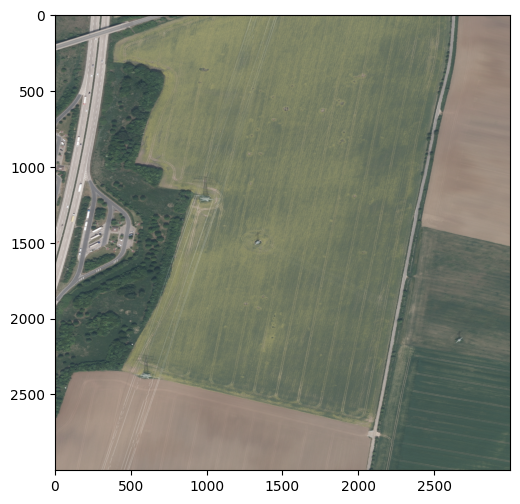

In [ ]:
# Step 1: Load the satellite image
satellite_image_path = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/test05.tif" # Replace with your image path
with rasterio.open(satellite_image_path) as src:
    # Read all bands
    data = src.read()

    # Check if we have 3 bands (RGB)
    if data.shape[0] == 3:
        # Reshape from (3, height, width) to (height, width, 3)
        satellite_image = np.moveaxis(data, 0, -1)
    else:
        raise ValueError("The image does not have 3 bands. Check your image data.")

# Plot the figure
fig, ax = plt.subplots(figsize=(5, 5))
# Show the RGB satellite image using imshow
ax.imshow(satellite_image)
#ax.axis('off')
# Set margins to zero and adjust subplot parameters
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

plt.tight_layout(pad=0)
plt.show()

## Add polygons

In [ ]:
polygons = parking_areas_ver[parking_areas_ver["id_rest"] == "lon_11.3531491_lat_50.9378362"]

In [ ]:
polygons

,id_rest,id_OSM_parking,type,geometry
226,lon_11.3531491_lat_50.9378362,way/372675074,car,"POLYGON ((11.35511 50.93810, 11.35504 50.93814..."
227,lon_11.3531491_lat_50.9378362,way/372675075,car,"POLYGON ((11.35576 50.93791, 11.35643 50.93794..."
228,lon_11.3531491_lat_50.9378362,way/372675076,car,"POLYGON ((11.35567 50.93820, 11.35561 50.93820..."
864,lon_11.3531491_lat_50.9378362,way/243445900,truck,"POLYGON ((11.35414 50.93787, 11.35422 50.93787..."


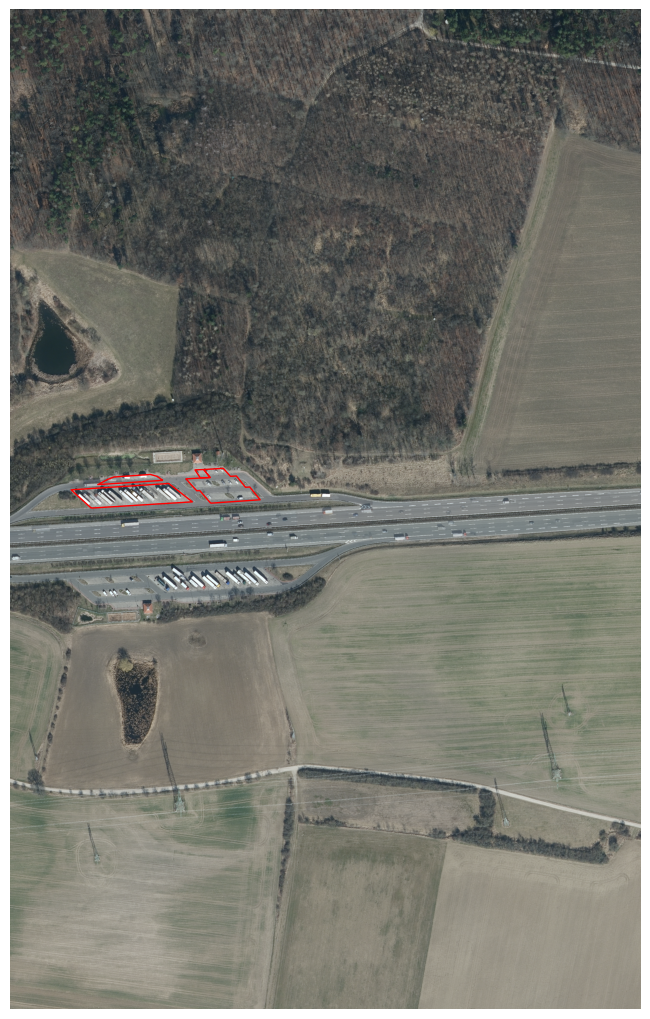

In [ ]:
# Load the satellite image
with rasterio.open("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/test02.tiff") as src:
    # Read all bands
    data = src.read()
    # Check if we have 3 bands (RGB)
    if data.shape[0] == 3:
        satellite_image = np.moveaxis(data, 0, -1)
    else:
        raise ValueError("The image does not have 3 bands. Check your image data.")

    # Plot the figure
    fig, ax = plt.subplots(figsize=(10, 10), frameon=False)

    # Show the satellite image
    show(src, ax=ax)

    # Reproject the GeoDataFrame if necessary
    if polygons.crs != src.crs:
        polygons = polygons.to_crs(src.crs)

    # Plot the filtered polygons on top of the satellite image
    polygons.plot(ax=ax, facecolor='none', edgecolor='red')

    # Remove axis
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


# Debugging

In [ ]:
debug_id = "lon_8.6630029_lat_50.2542348"
debug_bbox = rest_stations_ver.iloc[0].loc["bbox"]

In [ ]:
debug_bbox

[8.662868590361738, 50.24898152654641, 8.671281288359209, 50.25437556504614]

In [ ]:
def create_tiff_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square png map from a bounding box sourced from WMS services.

    Parameters:
    bbox (tuple): (left, bottom, right, top)
    wms_urls (dict): dictionary containing layer_names as keys and urls as values
    layer_extents (dict): dictionary containing layer_names as keys and layer extent tuples as values
    size (int): determines the size of the output png in pixels

    Returns:
    A square png image of the map.
    """


    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.

        Parameters:
        bbox1, bbox2 (tuple): tuple of bbox corners (left, bottom, right, top)

        Returns:
        True if bboxes intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        """
        Check whether an image is blank or not.

        Parameters:
        image (image object): image of WMS service

        Returns:
        True if image is blank, False otherwise.
        """
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, check whether image is completely white or black
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                # Check if the image is completely white or black
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # Raise error for other image mode
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False


    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based for the provided bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)
        wms_urls (dict): dictionary containing layer_names as keys and urls as values
        layer_extents: dictionary of layer names and their extent bounding boxes

        Returns:
        Layer name or None if no intersection
        """
        # Check WMSs one after the other until image is returned
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(2, 2),
                              format='image/png')
            # First, check if bounding box intersects
            if not bbox_intersects(bbox, extent):
                print(f"{layer} does not contain bounding box.")
            # Second, check whether image is blank
            elif is_blank_image(response):
                print(f"{layer} returns blank image.")
            # Return image
            else:
                print(f"{layer} returns image.")

                return layer
        return None


    def encapsulate_in_square_bbox(bbox):
        """
        Create encapsulating, square bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)

        Returns:
        A square bounding box that encapsulates input bounding box.
        """

        # Extract corners
        lat_min, lon_min, lat_max, lon_max = bbox

        # Calculate the midpoints of the existing bounding box
        mid_lat = (lat_max + lat_min) / 2
        mid_lon = (lon_max + lon_min) / 2

        # Calculate the max spans
        span_lat = (lat_max - lat_min) / 2
        span_lon = (lon_max - lon_min) / 2

        max_span = max(span_lat, span_lon)

        # Calculate new bbox corners
        lat_min_new = mid_lat - max_span
        lat_max_new = mid_lat + max_span
        lon_min_new = mid_lon - max_span
        lon_max_new = mid_lon + max_span

        square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

        return square_bbox


    # Create square bounding box from input bounding box
    square_bbox = encapsulate_in_square_bbox(bbox)

    # Determine the layer that intersects the bounding box
    chosen_layer = determine_layer_for_bbox(square_bbox, wms_urls, layer_extents)

    if chosen_layer == None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        # Correctly create a WebMapService object from chosen layer
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(size, size),
                              format='image/tiff')
    # Return the image
    return response

In [ ]:
# Test create_png_from_bbox function
try:
    # Input bbox to be tested
    response = create_tiff_from_bbox(biggest_rest_station_polygon, wms_urls, layer_extents, size = 3000)
    # Further code to handle the response
except ValueError as e:
    print(e)

In [ ]:
displayImage(response.read())

In [ ]:
type(response)

owslib.util.ResponseWrapper

In [ ]:
print("Image pixel dimensions", pixel_dimensions(response))

Image pixel dimensions (3000, 3000)


In [ ]:
# Specify downloading function

def download_map(image, filepath):

    # Assuming img_new is your image response object
    image_data = BytesIO(image.read())

    # Write the image data to a file
    with open(filepath, 'wb') as file:
        file.write(image_data.getvalue())

    # Provide the file path for downloading
    print("Download link:", filepath)

In [ ]:
# Download image

file_path = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/test05.png"

download_map(response, file_path)

Download link: /content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/test05.png


# Graveyard

In [ ]:
rest_stations_correct = []
for index, row in rest_stations.iterrows():
    if row["id"] in verified_service_stations_list:
        verified_service_stations.append(row)

rest_stations_correct = pd.DataFrame(verified_service_stations)
rest_stations_correct = verified_service_stations.reset_index()

<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
all_parkings.head()

,id_car,@id,name,id_rest,type,geometry
0,relation/13277622,relation/13277622,None,lon_10.2703215_lat_53.3301407,car,"MULTIPOLYGON (((10.26903 53.33039, 10.26926 53..."
1,relation/13277623,relation/13277623,None,lon_10.2712414_lat_53.331074,car,"MULTIPOLYGON (((10.26848 53.33228, 10.26872 53..."
2,relation/15482166,relation/15482166,None,lon_12.140788_lat_52.2431929,car,"MULTIPOLYGON (((12.14216 52.24271, 12.14213 52..."
3,relation/15482306,relation/15482306,None,lon_12.149456_lat_52.2449316,car,"MULTIPOLYGON (((12.14713 52.24497, 12.14717 52..."
4,way/31129920,way/31129920,Nord-Ostsee-Kanal,lon_9.323161_lat_54.0686721,car,"POLYGON ((9.32127 54.06898, 9.32314 54.06861, ..."


In [ ]:
all_parkings_correct = []
for index, row in all_parkings.iterrows():
    if row["id_rest"] in verified_service_stations_list:
        all_parkings_correct.append(row)

all_parkings_correct = pd.DataFrame(all_parkings_correct)
all_parkings_correct = all_parkings_correct.reset_index()

In [ ]:
all_parkings_correct

,index,id_car,@id,name,id_rest,type,geometry
0,5,way/33526884,way/33526884,Rastplatz Brinkum,lon_7.5846163_lat_53.2588511,car,"POLYGON ((7.5852698 53.2588255, 7.5861797 53.2..."
1,6,way/38125314,way/38125314,None,lon_7.2005154_lat_52.2816225,car,"POLYGON ((7.1968549 52.2812781, 7.1969165 52.2..."
2,9,way/48905621,way/48905621,None,lon_10.7306355_lat_50.559048,car,"POLYGON ((10.7308295 50.5591504, 10.7308651 50..."
3,10,way/48925325,way/48925325,None,lon_10.7298729_lat_50.5605634,car,"POLYGON ((10.7298595 50.5603334, 10.7297952 50..."
4,11,way/65260801,way/65260801,None,lon_13.9503161_lat_52.3112817,car,"POLYGON ((13.9536429 52.3107417, 13.9527447 52..."
...,...,...,...,...,...,...,...
1185,1601,None,way/1194289084,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.0438038 51.4678761, 11.0441384 51..."
1186,1602,None,way/1194289085,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.0443887 51.4681512, 11.0444483 51..."
1187,1603,None,way/1194289086,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.045028 51.468464, 11.0450594 51.4..."
1188,1604,None,way/1194289087,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.043748 51.467577, 11.0439927 51.4..."


In [ ]:
rest_stations_correct

NameError: name 'rest_stations_correct' is not defined

In [ ]:
def show_correct_service_station(index):

    service_station = rest_stations_correct.iloc[index,0]

            coord = create_coord(row[-1])

            # Store the map in a variable
            folium_map = create_folium_map(coord, service_stations=rest_stations_correct, parking=all_parkings_correct)

            # Clear the previous output and display the new map
            display(folium_map)



            coord = create_coord(row[-1])
    name = row["name"]
    id = row["id"]

    # Store the map in a variable
    folium_map = create_folium_map(coord, service_stations=rest_stations, parking=all_parkings)

In [ ]:
m = show_correct_service_station(2)
display(m)

None

In [ ]:
all_parkings.head()

,id_car,@id,name,id_rest,type,geometry
0,relation/13277622,relation/13277622,None,lon_10.2703215_lat_53.3301407,car,"MULTIPOLYGON (((10.26903 53.33039, 10.26926 53..."
1,relation/13277623,relation/13277623,None,lon_10.2712414_lat_53.331074,car,"MULTIPOLYGON (((10.26848 53.33228, 10.26872 53..."
2,relation/15482166,relation/15482166,None,lon_12.140788_lat_52.2431929,car,"MULTIPOLYGON (((12.14216 52.24271, 12.14213 52..."
3,relation/15482306,relation/15482306,None,lon_12.149456_lat_52.2449316,car,"MULTIPOLYGON (((12.14713 52.24497, 12.14717 52..."
4,way/31129920,way/31129920,Nord-Ostsee-Kanal,lon_9.323161_lat_54.0686721,car,"POLYGON ((9.32127 54.06898, 9.32314 54.06861, ..."
